In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

# Data loading

In [34]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0);df_RFM.head()

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_2_months_spend,RFM,next_2_months_spend
3386,13584.0,2011-02-06,2011-02-06,1,142.40,0.0,1-1-1,0.00
343,14553.0,2011-01-04,2011-05-05,2,312.32,0.0,1-1-2,546.95
1588,17929.0,2011-02-04,2011-09-23,4,698.50,263.5,2-1-1,136.00
1601,15053.0,2011-03-03,2011-07-06,2,478.60,0.0,1-1-1,0.00
678,13659.0,2011-01-23,2011-05-26,3,1550.85,0.0,1-1-1,0.00


In [35]:
y1 = df_RFM.RFM
y2 = df_RFM.next_2_months_spend
X = df_RFM.iloc[:,:-2]

In [36]:
# X_train, y_train, X_test, y_test = train_test_split(X, y1, random_state=42, stratefy)""
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [37]:
def df_transform(df):
    df_RFM = df
    df_RFM["T"] = (pd.to_datetime("2011-10-01") - pd.to_datetime(
                    df_RFM["first_purchase_date"]) ).apply(lambda x:x.days)
    df_RFM["recency"] = (pd.to_datetime(df_RFM["last_purchase_date"])  
                         - pd.to_datetime(df_RFM["first_purchase_date"])).apply(lambda x:x.days)
    df_RFM["frequency"] = (df_RFM["total_purchases"] - 1)
    data = df_RFM[["frequency", "recency", "T", "total_purchase_amount_x"]]
    data["monetary_value"] = data["total_purchase_amount_x"] / (1 + data["frequency"])
    data["monetary_value"] = data["monetary_value"].apply(lambda x:0.001 if x<=0 else x)
    return data

In [38]:
# train model
data = df_transform(X_train2)

# LTV

## Pareto-NPD

In [561]:
# Alternative method for LTV
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(data['frequency'], data['recency'], data['T'])

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.633748,0.023724,0.587248,0.680248
alpha,43.215597,2.183869,38.935215,47.495980
a,0.011330,0.004182,0.003133,0.019527
b,0.158515,0.046874,0.066642,0.250388


----

In [593]:
# Alternative method for LTV
from lifetimes.fitters.beta_geo_beta_binom_fitter import BetaGeoBetaBinomFitter

bgf = BetaGeoBetaBinomFitter(penalizer_coef=0.03)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoBetaBinomFitter: fitted with 2340 subjects, alpha: 0.22, beta: 1.87, delta: 0.77, gamma: 0.07>

In [421]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
alpha,0.217026,0.006755,0.203786,0.230266
beta,1.870713,0.059985,1.753142,1.988284
gamma,0.068338,0.004419,0.059678,0.076998
delta,0.773649,0.057392,0.661160,0.886137


----

In [719]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter

In [860]:
# Pareto-NBD Model
bgf = ParetoNBDFitter(penalizer_coef=0.04)

bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.ParetoNBDFitter: fitted with 2926 subjects, alpha: 59.19, beta: 7.81, r: 0.88, s: 0.03>

----

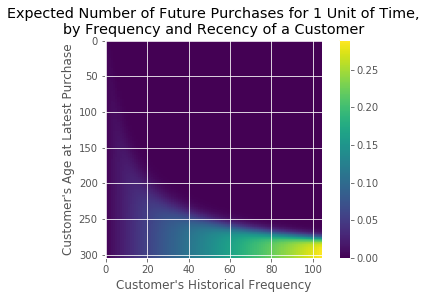

In [721]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf,
                             ylabel="Customer's Age at Latest Purchase")

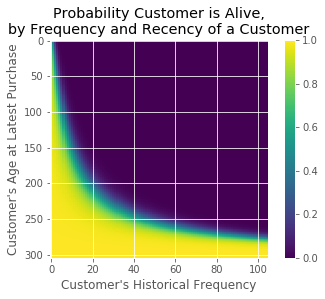

In [722]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf,
                             ylabel="Customer's Age at Latest Purchase")

In [746]:
t = 61
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
1054,32,302,303,5.524512
1530,34,302,303,5.860714
3254,34,288,299,5.915858
3336,34,276,285,6.158441
3610,83,301,304,14.054872


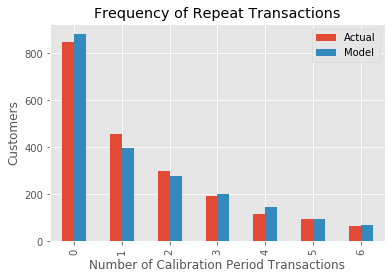

In [724]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Gamma-Gamma

In [748]:
data2 = df_RFM[["frequency", "recency", "T", "total_purchase_amount_x"]]
data2["monetary_value"] = data2["total_purchase_amount_x"] / (1 + data2["frequency"])

In [749]:
data2 = data2[["frequency", "recency", "T", "monetary_value"]]
data2["monetary_value"] = data2["monetary_value"].apply(lambda x:0.001 if x<=0 else x)

In [727]:
data2.corr()

,frequency,recency,T,monetary_value
frequency,1.000000,0.561654,0.344186,0.117757
recency,0.561654,1.000000,0.622771,0.084837
T,0.344186,0.622771,1.000000,-0.036882
monetary_value,0.117757,0.084837,-0.036882,1.000000


In [728]:
data2

,frequency,recency,T,monetary_value
815,0,0,8,344.330000
403,1,163,167,303.875000
1519,3,126,178,230.705000
2544,1,118,191,271.360000
2279,0,0,80,305.020000
...,...,...,...,...
822,10,287,289,386.740000
6,1,23,27,208.865000
115,5,278,297,174.130000
947,4,173,204,881.982000


In [862]:
from lifetimes import GammaGammaFittercomes

returning_customers_summary = data[data['frequency']>0]

ggf = GammaGammaFitter(penalizer_coef = 0.03)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1880 subjects, p: 1.63, q: 0.23, v: 1.86>


In [750]:
returning_customers_summary = data[data['frequency']>0]

In [751]:
returning_customers_summary["predict"] = ggf.conditional_expected_average_profit(
                                                        returning_customers_summary['frequency'],
                                                        returning_customers_summary['monetary_value']
                                                    )

## model checking

In [3]:
def RMSE(predict, actual):
    score = (((predict - actual)**2).sum() / actual.shape[0])**0.5
    print(score)
    return score

In [13]:
def lt_avg_pred(df, days):
    return (df.total_purchase_amount_x * days / df["T"]).mean()

In [14]:
def last_2m_prediction(df):
    return (df.last_2_months_spend).mean()

In [752]:
data2['predicted_purchases'] = data['predicted_purchases']#.apply(lambda x: proper_round(x))
data2["predict_avg_amount"] = returning_customers_summary["predict"]
data2["predict_avg_amount"][data2["frequency"] == 0] = data2[data2["frequency"] == 0]["monetary_value"]

In [753]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 1666 to 2881
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frequency            586 non-null    int64  
 1   recency              586 non-null    int64  
 2   T                    586 non-null    int64  
 3   monetary_value       586 non-null    float64
 4   predicted_purchases  586 non-null    float64
 5   predict_avg_amount   586 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 52.0 KB


In [754]:
sales_predict = data2["predict_avg_amount"] * data2["predicted_purchases"]

Validation checking

In [755]:
sales_actual2 = y_test2

In [756]:
RMSE = (((sales_predict - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE

1661.3067465062534

In [757]:
RMSE2 = ((((X_train.total_purchase_amount_x *61 / X_train["T"]).mean() - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE2

3139.8409800496606

In [758]:
RMSE3 = ((((X_train.last_2_months_spend).mean() - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE3

3128.8735477319383

P model training Score: 1514 2393 2370

Validation Score: 1661 3140 3129

The LTV model is clearly better than using just the mean.

# Other Methods
## Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [51]:
df = pd.read_csv("supervised_train.csv", index_col=0);
y = df.next_2_months_spend
X = df.iloc[:,:-1]
X = df_transform(X)

In [41]:
rf = RandomForestRegressor()
rf.fit(X, y)

rf_prediction = rf.predict(X)
# Score in Train
RMSE(rf_prediction, y)

631.4432020074099


631.4432020074099

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 9)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [45]:
gsrf = GridSearchCV(rf, 
                    random_grid#,scoring=f1_scorer
                   )
gsrf.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [46]:
pd.DataFrame(gsrf.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,962,963,964,965,966,967,968,969,970,971
mean_fit_time,0.461355,0.683221,0.93264,1.10683,1.32936,1.55031,1.76327,1.98537,2.28158,0.452056,...,1.44748,0.279827,0.42035,0.57092,0.703427,0.84851,0.991417,1.12707,1.26783,1.40867
std_fit_time,0.00556648,0.00281609,0.0443028,0.00520536,0.0112451,0.00795846,0.00909235,0.00715129,0.0167777,0.00512137,...,0.0151192,0.00392195,0.00630138,0.00800471,0.0136629,0.014206,0.011849,0.00971525,0.0164099,0.0182306
mean_score_time,0.00933418,0.0144836,0.0193234,0.0230808,0.0254307,0.0297832,0.0342514,0.0373506,0.0432828,0.00916548,...,0.0557092,0.012056,0.0171664,0.0222377,0.0278197,0.0328618,0.0381078,0.0439361,0.0479626,0.0532952
std_score_time,0.00078138,0.00068827,0.00168685,0.00137169,0.00061353,0.000646059,0.000895684,0.00113474,0.00085088,0.000271124,...,0.00197276,0.000564983,0.000481815,0.000194972,0.000840894,0.000474477,0.000578875,0.00120994,0.00031904,0.000751205
param_max_depth,10,10,10,10,10,10,10,10,10,10,...,None,None,None,None,None,None,None,None,None,None
param_max_features,auto,auto,auto,auto,auto,auto,auto,auto,auto,auto,...,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_min_samples_leaf,1,1,1,1,1,1,1,1,1,1,...,4,4,4,4,4,4,4,4,4,4
param_min_samples_split,2,2,2,2,2,2,2,2,2,5,...,5,10,10,10,10,10,10,10,10,10
param_n_estimators,100,150,200,250,300,350,400,450,500,100,...,500,100,150,200,250,300,350,400,450,500
params,"{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...","{'max_depth': 10, 'max_features': 'auto', 'min...",...,"{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm...","{'max_depth': None, 'max_features': 'sqrt', 'm..."


In [47]:
gsrf.best_params_

{'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [13]:
df = pd.read_csv("supervised_test.csv", index_col=0);
y = df.next_2_months_spend
X = df.iloc[:,:-1]
X = df_transform(X)

/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
# Validation for comparing with ML model
RMSE(rf.predict(X), y)

927.0907296852886


927.0907296852886

In [ ]:
# to compare with LTV

In [48]:
df = pd.read_csv("supervised_all.csv", index_col=0);
y = df.next_2_months_spend
X = df.iloc[:,:-1]
X = df_transform(X)
rf = RandomForestRegressor(max_depth = 50,
                             max_features = 'auto',
                             min_samples_leaf = 2,
                             min_samples_split = 10,
                             n_estimators = 100
                            )
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
# to compare with LTV
data = df_transform(X_test2)
RMSE(rf.predict(data), y_test2)

1808.161064332371


1808.161064332371

Worse than LTV

## linear Regression

In [31]:
df = pd.read_csv("supervised_all.csv", index_col=0);
y = df.next_2_months_spend
X = df.iloc[:,:-1]
X = df_transform(X)
rf = RandomForestRegressor()
rf.fit(X, y)

/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
# to compare with LTV
data = df_transform(X_test2)
RMSE(rf.predict(data), y_test2)

1774.0251487882329


/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/vince/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


1774.0251487882329

## SVM

In [52]:
df = pd.read_csv("supervised_train.csv", index_col=0);
y = df.next_2_months_spend
X = df.iloc[:,:-1]
X = df_transform(X)

In [56]:
svm = SVR()
svm.fit(X, y)

svm_prediction = svm.predict(X)
# Score in Train
RMSE(svm_prediction, y)

2682.0596263977036


2682.0596263977036

# Final Model

In [771]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0);

In [865]:
df_RFM_test = pd.read_csv("fdb_RFM3_test.csv", index_col=0);

In [864]:
# final model
data = df_transform(df_RFM)
# Model
bgf = ParetoNBDFitter(penalizer_coef=0.04)
bgf.fit(data['frequency'], data['recency'], data['T'])
returning_customers_summary = data[data['frequency']>0]
ggf = GammaGammaFitter(penalizer_coef = 0.03)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1880 subjects, p: 1.63, q: 0.23, v: 1.86>

In [876]:
# Model Predict
def predict_at_one_time(df, bgf, ggf, t=61):
    data_test = df_transform(df)
    data_test['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                            data_test['frequency'], data_test['recency'], data_test['T'])
    returning_customers_summary2 = data_test[data_test['frequency']>0]
    returning_customers_summary2["predict"] = ggf.conditional_expected_average_profit(
                                                            returning_customers_summary2['frequency'],
                                                            returning_customers_summary2['monetary_value'] )
    data_test["predict_avg_amount"] = returning_customers_summary2["predict"]
    data_test["predict_avg_amount"][data_test["frequency"] == 0] = data_test[data_test["frequency"] == 0]["monetary_value"]
    data_test["sales_predict"] = data_test["predict_avg_amount"] * data_test["predicted_purchases"]
    return data_test

In [877]:
data_test = predict_at_one_time(df_RFM_test, bgf, ggf, t=61)

In [880]:
sales_actual = df_RFM["next_2_months_spend"]
sales_actual2 = df_RFM_test["next_2_months_spend"]

Trainning Scores for final Model

In [881]:
# LTV
RMSE(predict_at_one_time(df_RFM, bgf, ggf, t=61).sales_predict,sales_actual)

1546.8674916135808


1546.8674916135808

In [882]:
# lifetime average prediction
RMSE(lt_avg_pred(df_RFM, 61),sales_actual)

2557.094099492046


2557.094099492046

In [883]:
# latest period prediction
RMSE(last_2m_prediction(df_RFM),sales_actual)

2540.1500123724904


2540.1500123724904

Test Scores for final Model

In [873]:
RMSE(data_test.sales_predict,sales_actual2)

613.2913604905153


613.2913604905153

In [816]:
# lifetime average prediction
RMSE(lt_avg_pred(df_RFM, 61),sales_actual2)

805.8475508762967


805.8475508762967

In [818]:
# latest period prediction
RMSE(last_2m_prediction(df_RFM),sales_actual2)

716.5673492484322


716.5673492484322

## Prediction

In [892]:
data_test["LTV"] = data_test["predicted_purchases"]*data_test["predict_avg_amount"]

In [893]:
a =data_test["LTV"].sum()
b =df_RFM_test["next_2_months_spend"].sum()
c = df_RFM_test["last_2_months_spend"].sum()

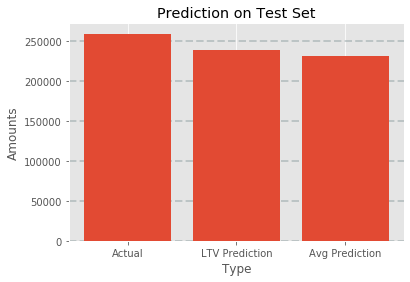

In [894]:
bar = [b,a,c]
labels = ['Actual', 'LTV Prediction', 'Avg Prediction']
plt.xticks(range(len(bar)), labels)
plt.xlabel('Type')
plt.ylabel('Amounts')
plt.title('Prediction on Test Set')
plt.bar(range(len(bar)), bar) 
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.5)

plt.show()

## Churn Warning

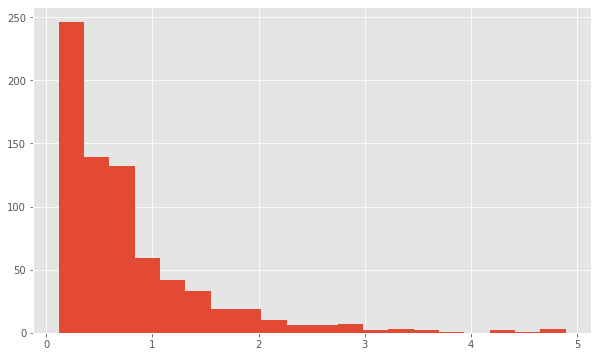

In [895]:
data_test["predicted_purchases"].hist(figsize = (10,6),bins=20)

In [896]:
data_test.sort_values("LTV", ascending=False).head(10)

,frequency,recency,T,total_purchase_amount_x,monetary_value,predicted_purchases,predict_avg_amount,sales_predict,LTV
2802,1,97,263,21535.90,10767.950000,0.318241,20393.193511,6489.955400,6489.955400
2915,9,257,288,24987.75,2498.775000,1.707702,2637.259115,4503.651938,4503.651938
1539,8,152,183,10217.48,1135.275556,2.188584,1206.685631,2640.932311,2640.932311
67,4,80,102,6348.08,1269.616000,1.809211,1439.955734,2605.183319,2605.183319
2411,1,10,11,1631.77,815.885000,1.601183,1548.433965,2479.326336,2479.326336
2980,1,2,103,4016.66,2008.330000,0.624501,3806.391413,2377.093424,2377.093424
393,3,171,207,9229.54,2307.385000,0.866054,2738.811226,2371.959133,2371.959133
679,3,203,209,8516.77,2129.192500,0.868136,2527.357626,2194.089250,2194.089250
2873,7,248,268,11278.48,1409.810000,1.449989,1512.003992,2192.388750,2192.388750
2538,26,295,300,12558.70,465.137037,4.545966,473.807857,2153.914282,2153.914282


## 80/20 Rule? Who are the VIP?

In [897]:
data_test.sort_values("LTV", ascending=False).head(int(data_test.shape[0]/10))["LTV"].sum() / data_test["LTV"].sum()

0.42247265128595796

In [898]:
top20_LTV_share = data_test.sort_values("LTV", ascending=False).head(int(data_test.shape[0]/5))["LTV"].sum() / data_test["LTV"].sum()

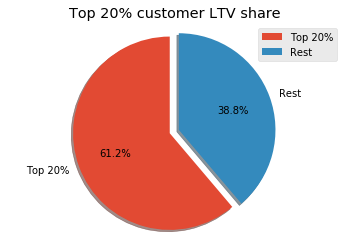

In [899]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Top 20%', 'Rest'
sizes = [top20_LTV_share.round(3), 1- top20_LTV_share.round(3)]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend()
ax1.set_title("Top 20% customer LTV share")

plt.show()

## take two individual as example

In [916]:
# Jessie
df_RFM_test.loc[1236]

CustomerID                      16010
first_purchase_date        2010-12-12
last_purchase_date         2011-04-08
total_purchases                     3
total_purchase_amount_x         407.5
last_2_months_spend                 0
RFM                             1-1-1
next_2_months_spend                 0
T                                 293
recency                           117
frequency                           2
Name: 1236, dtype: object

In [912]:
data_test.loc[1236]

frequency                    2.000000
recency                    117.000000
T                          293.000000
total_purchase_amount_x    407.500000
monetary_value             135.833333
predicted_purchases          0.434519
predict_avg_amount         178.993758
sales_predict               77.776133
LTV                         77.776133
Name: 1236, dtype: float64

In [924]:
bgf.conditional_probability_alive(data_test['frequency'], data_test['recency'], data_test['T']).loc[1236]

0.8889886237602888

In [914]:
# Ellie divide 2.2
df_RFM_test.loc[2750]

CustomerID                      17287
first_purchase_date        2010-12-02
last_purchase_date         2011-09-26
total_purchases                     6
total_purchase_amount_x         880.3
last_2_months_spend            177.89
RFM                             1-1-2
next_2_months_spend            183.81
T                                 303
recency                           298
frequency                           5
Name: 2750, dtype: object

In [915]:
data_test.loc[2750]

frequency                    5.000000
recency                    298.000000
T                          303.000000
total_purchase_amount_x    880.300000
monetary_value             146.716667
predicted_purchases          0.979101
predict_avg_amount         162.416280
sales_predict              159.022008
LTV                        159.022008
Name: 2750, dtype: float64

In [923]:
bgf.conditional_probability_alive(data_test['frequency'], data_test['recency'], data_test['T']).loc[2750]

0.9990540857344504